# Enoncé
## Contexte
**Mon rôle** : data scientist prestataire pour Olist

**Commanditaire** : Olist (https://olist.com/pt-br/)

**Activité de l'entreprise :** entreprise brésilienne qui propose une solution de vente sur les marketplaces en ligne

**Projet :** segmentation des clients pour leurs campagnes de communication

**Type de Mission :** classification non supervisés

## Attendus
**But de la mission :** comprendre les différents types d’utilisateurs grâce à leur comportement et à leurs données personnelles

**Détails de la mission :** fournir à l’équipe marketing une description actionable de votre segmentation et de sa logique sous-jacente pour une utilisation optimale, ainsi qu’une proposition de contrat de maintenance basée sur une analyse de la stabilité des segments au cours du temps

données anonymisée ==> https://www.kaggle.com/olistbr/brazilian-ecommerce (comportant des informations sur l’historique de commandes, les produits achetés, les commentaires de satisfaction, et la localisation des clients depuis janvier 2017)

comprendre les différents types d'utilisateurs --> utiliser des méthodes non supervisées pour regrouper des clients de profils similaires --> utilisées par l’équipe Marketing pour mieux communiquer

**Problèmes :** Olist n'a pas fourni beaucoup de données --> ressources limitées --> dû fournir l’ensemble des données, alors que seuls 3 % des clients ont réalisé plusieurs commandes --> les données à disposition suffiront pour réaliser un premier clustering

**Etapes demandées :**
Vous sortez tout juste d’une réunion de brief avec votre équipe. Voici un récapitulatif de votre mission :
- Réaliser une courte analyse exploratoire.
- Tester différents modèles de classification/segmentation afin de différencier les bons et moins bons clients en termes de commandes et de satisfaction sur l’ensemble des clients
- Faire une recommandation de fréquence à laquelle la segmentation doit être mise à jour pour rester pertinente, afin de pouvoir effectuer un devis de contrat de maintenance

/!\ Pour information, le code fourni doit respecter la convention PEP8, pour être utilisable par Olist. /!\

**Script concerné :** 
- **Un notebook de l'analyse exploratoire (non cleané, pour comprendre votre démarche).**
- Un notebook (ou code commenté au choix) d’essais des différentes approches de modélisation (non cleané, pour comprendre votre démarche).
- Un notebook de simulation pour déterminer la fréquence nécessaire de mise à jour du modèle de segmentation.

# Librairies, paramétrage et donnés
## Mise à jour des librairies

In [1]:
'''
import re
import pip
listLib = !pip list --outdated --format freeze
listLib = list(listLib)
listLib = [re.sub('(\=)+(.)+$', '', i) for i in listLib]
pip.main(['install'] + listLib + ['--upgrade'] + ['--user'] + ['--no-warn-script-location'])
!pip list --outdated
'''

"\nimport re\nimport pip\nlistLib = !pip list --outdated --format freeze\nlistLib = list(listLib)\nlistLib = [re.sub('(\\=)+(.)+$', '', i) for i in listLib]\npip.main(['install'] + listLib + ['--upgrade'] + ['--user'] + ['--no-warn-script-location'])\n!pip list --outdated\n"

## Importations des librairies

In [2]:
import os
import re

# Gestion des données
import pandas as pd
import numpy as np

# Gestion temporelle
import datetime as dt
import calendar

# Gestion des graphiques
import matplotlib.pyplot as plt
from matplotlib import cm
import seaborn as sns

## Paramétrages du notebook

In [3]:
# Format des résultats affichés
pd.set_option('display.max_columns', None) # display.max_columns : contrôle le nombre de colonnes à imprimer (int ou None pour imprimer toutes les colonnes)
pd.set_option('max_colwidth', None) # Vous pouvez augmenter la largeur en passant un int (ou mettre au max en passant None)
pd.set_option("display.max_rows", None) # Pour modifier le nombre de lignes, vous devez modifier l' option max_rows 
pd.options.display.float_format = '{:.2f}'.format # enlève le format d'affichage : nombre scientifique

# Pour afficher les graphiques dans la continuité du code, et non pas dans une fenêtre à part:
%matplotlib inline

## Importations des données

Ayant beaucoup de fichiers de données, je vais les importer automatiquement.

In [4]:
paths = "E:/Formations/6. Diplôme Data Scientist/Projet/Projet-5"
listCSV = os.listdir(paths)
listCSV = [x for x in listCSV if '.csv' in x]
listCSV

['olist_customers_dataset.csv',
 'olist_geolocation_dataset.csv',
 'olist_order_items_dataset.csv',
 'olist_order_payments_dataset.csv',
 'olist_order_reviews_dataset.csv',
 'olist_orders_dataset.csv',
 'olist_products_dataset.csv',
 'olist_sellers_dataset.csv',
 'product_category_name_translation.csv']

In [5]:
listDF = []
for csv in listCSV:
    # j'enlève les parties du nom qui ne sont pas intéressantes
    strPath = re.sub('_dataset','',re.sub('olist_','',re.sub('.csv','',csv)))
    # je créé le nouveau df
    globals()['df_'+strPath] = pd.read_csv(paths+"/"+csv
                                             , sep=",", decimal = '.', encoding="utf-8")
    # j'ajoute son nom dans une liste pour pouvoir les manipuler dans la partie Nettoyage
    listDF = listDF + ['df_'+strPath]
    # j'affiche son nom
    print('df_'+strPath)
    print('-------------------')

df_customers
-------------------
df_geolocation
-------------------
df_order_items
-------------------
df_order_payments
-------------------
df_order_reviews
-------------------
df_orders
-------------------
df_products
-------------------
df_sellers
-------------------
df_product_category_name_translation
-------------------


# Nettoyage
## Format des données
Je vais commencer par modifier les types des variables. Ici, je définie que :
   - les identifiants des df sont des variables catégorielles
   - les codes postaux (zip code en anglais) sont des variables catégorielles sur 5 chiffres obligatoirement
   - les dates sont au format date
   - l'ensemble des variables STRING doivent être en majuscule (pour faciliter le traitement et l'analyse des données)

In [6]:
for df in listDF:
    print('--------------')
    print(df)
    print('Il y a {:,} lignes dans le df et {:,} colonnes.'.format(globals()[df].shape[0]
                                                                   , globals()[df].shape[1]).replace(',',' '))
    print('--------------')
    
    # je récupère la liste des variables du df en cours
    listVar = globals()[df].columns.to_list()
    # je récupère la ou les variables à transformer en string : identifiant et cp (s'il y a)
    listVarStr = [var1 for var1 in listVar if (('_id' in var1) | ('zip_code' in var1)) & 
                  (globals()[df][var1].dtypes != object)]
    
    # s'il y a au moins une variable à transformer
    if len(listVarStr) > 0:
        # pour chaque variable à transformer
        for var2 in listVarStr:
            # je la transforme en variable string
            globals()[df][var2] = globals()[df][var2].astype(str)
            # si la variable est un cp, 
            if 'zip_code' in var2:
                # je force les valeurs à être obligatoirement sur 5 chiffres (rajout de 0 si le cp est sur 4 chiffres)
                globals()[df][var2] = globals()[df][var2].str.zfill(5)
    
    # je récupère la liste des variables object
    listVarString = globals()[df].select_dtypes(object).columns.to_list()
    # je récupère la liste des variables object ne faisant pas parti de la liste de variables précédemment transformées
    listVarDate = [var3 for var3 in listVarString if var3 not in listVarStr]
    
    # s'il y a au moins une variable object
    if len(listVarDate) > 0:
        # pour chaque variable object
        for var4 in listVarDate:
            # je récupère la première valeur non nulle
            testRow = globals()[df][~globals()[df][var4].isna()][var4].values[0]
            # si elle contient une date,
            if re.search("([0-9][0-9])+(-|/)([0-9][0-9])+(-|/)([0-9][0-9])+",testRow):
                # alors je la transforme en date en fonction de son format 
                if "/" in testRow: # 01/01/01
                    globals()[df][var4] = pd.to_datetime(globals()[df][var4], format='%Y/%m/%d %H:%M:%S')
                else: # 01-01-01
                    globals()[df][var4] = pd.to_datetime(globals()[df][var4], format='%Y-%m-%d %H:%M:%S')
        
    # enfin j'affiche toutes les colonnes, leur type et le nombre de valeur manquantes
    df_infos = pd.DataFrame(globals()[df].dtypes, columns = ['types'])
    df_infos['na_nb'] = globals()[df].isna().sum()
    df_infos['na_pctg'] = round(globals()[df].isna().mean()*100,2)
    print(df_infos)
    print()
    
    # je récupère la liste des variables object
    listVarString = globals()[df].select_dtypes(object).columns.to_list()
    
    # je mets toutes les variables object en majuscule
    for var5 in listVarString:
        globals()[df][var5] = globals()[df][var5].str.upper()
        if globals()[df][var5].nunique() <= 20:
            print(var5,':')
            print(globals()[df][var5].value_counts())
            print()
            
    # ainsi qu'un échantillon aléatoire de 10 lignes
    print(globals()[df].sample(10))
    
    del listVar, listVarStr, listVarString, listVarDate, df_infos
    print('--------------')

--------------
df_customers
Il y a 99 441 lignes dans le df et 5 colonnes.
--------------
                           types  na_nb  na_pctg
customer_id               object      0     0.00
customer_unique_id        object      0     0.00
customer_zip_code_prefix  object      0     0.00
customer_city             object      0     0.00
customer_state            object      0     0.00

                            customer_id                customer_unique_id  \
14231  BA652878434F2EF707743BDF9444B46D  F7A5BCA390735DFCF029B4E292DF7815   
2522   D8EA195B140DBF4F97812F4848F4676E  18F4B2B0A9D6B393FFEA532C2B8D6E55   
52898  0B26BB0F88FF2869DC89FC3703473CD9  D6602551AFBB5CAF929F554EB476F980   
50943  9665FA0EDAAF2D634F3E834EFD219267  46FA1EDAE9B7921E3C9588F24AF56EE7   
80509  5D442FD431E8112816463237246A2B6B  EA6184B812DF993F07FD9D7EDCA1C246   
84550  222045E44210159D75AC338D6FD1BD05  32DFC89D6563E6868106A8C7711AD8D8   
92292  B129D989BD1940915EFBDC2D239386D3  0B9779C6DDF61DB3641EDD60F13BE109   

                                  types  na_nb  na_pctg
review_id                        object      0     0.00
order_id                         object      0     0.00
review_score                      int64      0     0.00
review_comment_title             object  87656    88.34
review_comment_message           object  58247    58.70
review_creation_date     datetime64[ns]      0     0.00
review_answer_timestamp  datetime64[ns]      0     0.00

                              review_id                          order_id  \
47874  6EED2D0DF39A1AFA42C2F95B76835C22  032CF75B6991A44F9583D652730066D9   
9461   05C7FEBDA16E6264E6E784E5F18FE3B2  9F9FBC0E7D68D4FCBECC49A5E92B41CF   
39652  8DE20C189A1D16BC8431FA7E73E8D4AC  BC314EA94634EC397DF2B65D3BCB2C1C   
5330   96E0C98F292FB4B937318A1C0F1D8C97  ECE7B7CBA1247B9AC059FC6A6528A075   
91066  4650B6C3CC59899F66A8F91C139058E3  D87739E1A489341831EC68B0876174F0   
8812   51E7DCE30DF80ADC973A808B2733E845  25DE47610B1FE93D066D999828C0FE57   
35740  27728

Il a des commandes qui sont annulés ou indisponible. Je vais les supprimer de l'ensemble de la base de données.

## Commande non abouties

In [7]:
listInvalidOrder = df_orders[df_orders['order_status'].isin(['CANCELED','UNAVAILABLE'])]['order_id'].unique().tolist()
print("Cela concerne",len(listInvalidOrder),'commandes.')
for df in listDF:
    if 'order' in df:
        globals()[df] = globals()[df][~globals()[df]['order_id'].isin(listInvalidOrder)]
del listInvalidOrder

Cela concerne 1234 commandes.


In [8]:
listDF

['df_customers',
 'df_geolocation',
 'df_order_items',
 'df_order_payments',
 'df_order_reviews',
 'df_orders',
 'df_products',
 'df_sellers',
 'df_product_category_name_translation']

# Analyse

Il existe différents types de segmentation client dans le métier du marketing. Au vue des données disponibles, je vais appliquer la *segmentation RFM* (Récence, Fréquence, Montant) qui définit le comportement du clients envers l'entreprise, puis je l'analyserais.

## Statistiques descriptives générales

Je vais commencer par regarder les statistiques générales des variables des df.

In [9]:
df_customers.describe(include = 'all')

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state
count,99441,99441,99441,99441,99441
unique,99441,96096,14994,4119,27
top,06B8999E2FBA1A1FBC88172C00BA8BC7,8D50F5EADF50201CCDCEDFB9E2AC8455,22790,SAO PAULO,SP
freq,1,17,142,15540,41746


Je peux voir que le site a près de 100 000 clients/prospects répartis sur plus de 4 000 villes. 
Il serait intéressant de vérifier si :
- il existe un ou plusieurs adresse par client

In [10]:
df_geolocation.describe(include = 'all')

,geolocation_zip_code_prefix,geolocation_lat,geolocation_lng,geolocation_city,geolocation_state
count,1000163,1000163.00,1000163.00,1000163,1000163
unique,19015,NaN,NaN,8011,27
top,24220,NaN,NaN,SAO PAULO,SP
freq,1146,NaN,NaN,135800,404268
mean,NaN,-21.18,-46.39,NaN,NaN
std,NaN,5.72,4.27,NaN,NaN
min,NaN,-36.61,-101.47,NaN,NaN
25%,NaN,-23.60,-48.57,NaN,NaN
50%,NaN,-22.92,-46.64,NaN,NaN
75%,NaN,-19.98,-43.77,NaN,NaN


Ce df est un simple df informative. En effet, il permet de relier un code postal à des points de latitude et longitude.

In [11]:
df_order_items.describe(include = 'all', datetime_is_numeric = True)

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
count,112101,112101,112101,112101,112101,112101.00,112101.00
unique,98199,21,32729,3053,NaN,NaN,NaN
top,8272B63D03F5F79C56E9E4120AEC44EF,1,ACA2EB7D00EA1A7B8EBD4E68314663AF,6560211A19B47992C3666CC44A7E94C0,NaN,NaN,NaN
freq,21,98199,527,2025,NaN,NaN,NaN
mean,NaN,NaN,NaN,NaN,2018-01-07 19:28:06.622447872,120.38,19.99
min,NaN,NaN,NaN,NaN,2016-09-19 23:11:33,0.85,0.00
25%,NaN,NaN,NaN,NaN,2017-09-20 23:24:26,39.90,13.08
50%,NaN,NaN,NaN,NaN,2018-01-26 13:59:24,74.90,16.27
75%,NaN,NaN,NaN,NaN,2018-05-10 14:53:13,134.90,21.15
max,NaN,NaN,NaN,NaN,2020-04-09 22:35:08,6735.00,409.68


Ce df informe sur les produits (nom, prix et frais de port, date limite d'expédition) présent dans une commande et le vendeur au près de qui a été passé la commande. Je peux déjà voir qu'il y a en base près de 100 000 commandes, soit presqu'autant que de clients/prospects. La base ne contient donc que des clients/prospects ayant bien passé au moins 1 commande ?
Il y a différents points qu'il serait intéressant de vérifier :
- chaque commande ne concerne-t-elle qu'un seul vendeur ?
- les produits d'une même commande peuvent-elle avoir une date limite d'expédition différente ?

In [12]:
df_order_payments.describe(include = 'all')

,order_id,payment_sequential,payment_type,payment_installments,payment_value
count,102573,102573.00,102573,102573.00,102573.00
unique,98206,NaN,4,NaN,NaN
top,FA65DAD1B0E818E3CCC5CB0E39231352,NaN,CREDIT_CARD,NaN,NaN
freq,29,NaN,75905,NaN,NaN
mean,NaN,1.09,NaN,2.85,153.44
std,NaN,0.70,NaN,2.69,214.76
min,NaN,1.00,NaN,0.00,0.00
25%,NaN,1.00,NaN,1.00,56.80
50%,NaN,1.00,NaN,1.00,100.00
75%,NaN,1.00,NaN,4.00,171.61


Ce df concerne le paiement des commandes (moyen de paiement et prix total).

In [13]:
df_order_reviews.describe(include = 'all', datetime_is_numeric = True)

,review_id,order_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp
count,98018,98018,98018.00,11417,40156,98018,98018
unique,97270,97473,NaN,3956,34832,NaN,NaN
top,69A1068C3128A14994E3E422E4539E04,C88B1D1B157A9999CE368F218A407141,NaN,RECOMENDO,MUITO BOM,NaN,NaN
freq,3,3,NaN,824,368,NaN,NaN
mean,NaN,NaN,4.12,NaN,NaN,2018-01-13 10:32:38.334183424,2018-01-16 13:55:01.997765632
min,NaN,NaN,1.00,NaN,NaN,2016-10-06 00:00:00,2016-10-07 18:32:28
25%,NaN,NaN,4.00,NaN,NaN,2017-09-24 00:00:00,2017-09-27 23:12:44.750000128
50%,NaN,NaN,5.00,NaN,NaN,2018-02-02 00:00:00,2018-02-05 13:45:38
75%,NaN,NaN,5.00,NaN,NaN,2018-05-16 00:00:00,2018-05-20 13:32:43.249999872
max,NaN,NaN,5.00,NaN,NaN,2018-08-31 00:00:00,2018-10-29 12:27:35


Ce df contient les avis des clients concernant leur commande (score - de 1 à 5 -, message et date).

In [14]:
df_orders.describe(include = 'all', datetime_is_numeric = True)

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
count,98207,98207,98207,98207,98188,97583,96470,98207
unique,98207,98207,6,NaN,NaN,NaN,NaN,NaN
top,E481F51CBDC54678B7CC49136F2D6AF7,9EF432EB6251297304E76186B10A928D,DELIVERED,NaN,NaN,NaN,NaN,NaN
freq,1,1,96478,NaN,NaN,NaN,NaN,NaN
mean,NaN,NaN,NaN,2018-01-01 01:40:38.269115136,2018-01-01 13:06:46.455351040,2018-01-04 21:46:36.917465344,2018-01-14 12:41:33.581683456,2018-01-24 20:19:15.876872192
min,NaN,NaN,NaN,2016-09-04 21:15:19,2016-09-15 12:16:38,2016-10-08 10:34:01,2016-10-11 13:46:32,2016-10-04 00:00:00
25%,NaN,NaN,NaN,2017-09-13 09:55:58.500000,2017-09-13 19:02:00,2017-09-15 21:26:13,2017-09-25 22:15:09.500000,2017-10-04 00:00:00
50%,NaN,NaN,NaN,2018-01-19 17:07:24,2018-01-20 09:10:02,2018-01-24 13:48:56,2018-02-02 19:32:21,2018-02-15 00:00:00
75%,NaN,NaN,NaN,2018-05-04 21:00:02,2018-05-05 10:00:01.500000,2018-05-08 13:50:00,2018-05-15 22:54:48.500000,2018-05-28 00:00:00
max,NaN,NaN,NaN,2018-09-03 09:06:57,2018-09-03 17:40:06,2018-09-11 19:48:28,2018-10-17 13:22:46,2018-10-25 00:00:00


Ce df contient les informations générales de la commande (acheteur, statut, dates). Je peux voir que les commandes de cette base de données sont celles passées entre septembre 2016 et octobre 2018. De plus, la majorité des commandes ont un statut délivrée.

In [15]:
df_products.describe(include = 'all')

,product_id,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm
count,32951,32341,32341.00,32341.00,32341.00,32949.00,32949.00,32949.00,32949.00
unique,32951,73,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,1E9E8EF04DBCFF4541ED26657EA517E5,CAMA_MESA_BANHO,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,1,3029,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,NaN,48.48,771.50,2.19,2276.47,30.82,16.94,23.20
std,NaN,NaN,10.25,635.12,1.74,4282.04,16.91,13.64,12.08
min,NaN,NaN,5.00,4.00,1.00,0.00,7.00,2.00,6.00
25%,NaN,NaN,42.00,339.00,1.00,300.00,18.00,8.00,15.00
50%,NaN,NaN,51.00,595.00,1.00,700.00,25.00,13.00,20.00
75%,NaN,NaN,57.00,972.00,3.00,1900.00,38.00,21.00,30.00


Ce df décrit l'ensemble des produits (nom, catégorie, description, tailles/poids), soit dans les 30 000 produits.

In [16]:
df_sellers.describe(include = 'all')

,seller_id,seller_zip_code_prefix,seller_city,seller_state
count,3095,3095,3095,3095
unique,3095,2246,611,23
top,3442F8959A84DEA7EE197C632CB2DF15,14940,SAO PAULO,SP
freq,1,49,694,1849


Ce df décrit l'ensemble des vendeurs du site, soit un peu plus de 3 000.

In [17]:
df_product_category_name_translation.describe(include = 'all')

,product_category_name,product_category_name_english
count,71,71
unique,71,71
top,BELEZA_SAUDE,HEALTH_BEAUTY
freq,1,1


Ce df n'est qu'un df informatif, il relie chaque catégorie de produits à sa traduction anglais.

Maintenant que j'ai eu un aperçu général de toutes les données. Je peux passer à la création de la segmentation RFM.

## Segmentation RFM

In [18]:
# df des commandes avec les id clients
df_orders_cust = pd.merge(df_orders
                    , df_customers[['customer_id','customer_unique_id']]
                    , on = 'customer_id')

# df des montants totaux des commmandes
df_orders_pay = df_order_payments.groupby('order_id', as_index = False)['payment_value'].sum()

# ajout des montants totaux au df des commandes/clients
df_orders_cust = pd.merge(df_orders_cust
                          , df_orders_pay[['order_id','payment_value']]
                          , on = 'order_id'
                          , how = 'inner')
del df_orders_pay

In [19]:
# création de la segmentation RFM
df_RFM = df_orders_cust.groupby(['customer_unique_id'], as_index=False)
df_RFM = df_RFM.agg(Récence = ('order_purchase_timestamp', max) # date de la dernière commande
                    , Fréquence = ('order_id', 'count')         # Fréquence : nombre de commandes passées sur la période
                    , Montant = ('payment_value', 'sum'))       # Montant : somme des commandes passées sur la période
df_RFM['Récence'] = (df_RFM['Récence'].max() - df_RFM['Récence']).dt.days # Récence : nombre de jours depuis la dernière commande
df_RFM.head()

,customer_unique_id,Récence,Fréquence,Montant
0,0000366F3B9A7992BF8C76CFDF3221E2,115,1,141.90
1,0000B849F77A49E4A4CE2B2A4CA5BE3F,118,1,27.19
2,0000F46A3911FA3C0805444483337064,541,1,86.22
3,0000F6CCB0745A6A4B88665A16C9F078,325,1,43.62
4,0004AAC84E0DF4DA2B147FCA70CF8255,292,1,196.89


La segmentation RFM est créée, je vais l'analyser avant de l'exporter.
## Analyse 
### RFM

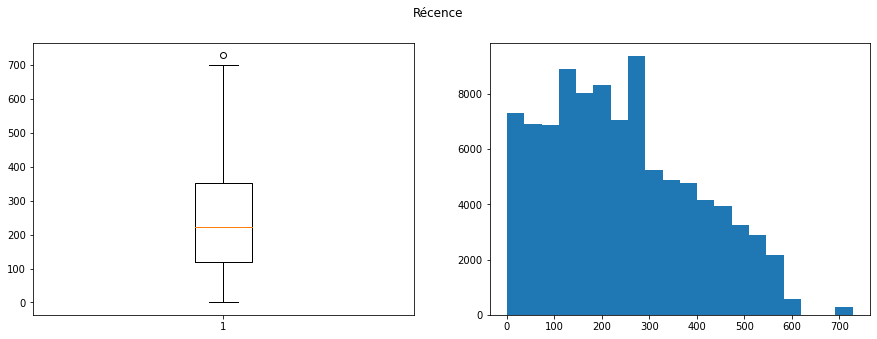

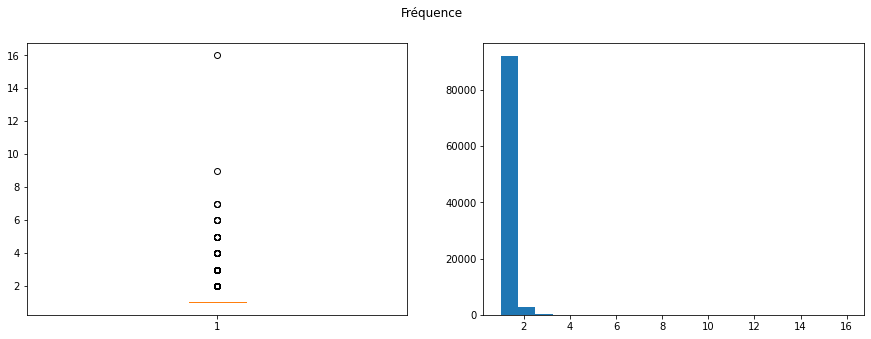

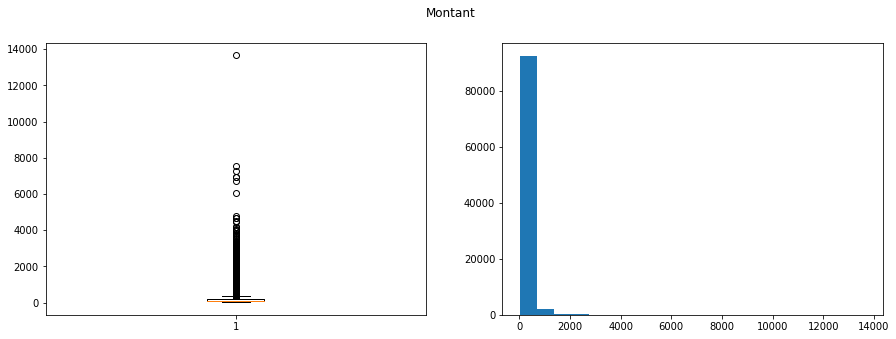

In [20]:
for var in df_RFM.columns[1:]:
    fig, (ax1, ax2) = plt.subplots(1,2)
    fig.suptitle(var)
    fig.set_figheight(5)
    fig.set_figwidth(15)
    ax1.boxplot(df_RFM[var])
    ax2.hist(df_RFM[var], bins = 20)
    plt.show();

Au vue des distributions des 3 variables, on voit très nettement que la base de données est majoritairement composée de nouveaux clients ayant dépensés moins de 1 000€ sur ces 2 années.

### Satisfaction client

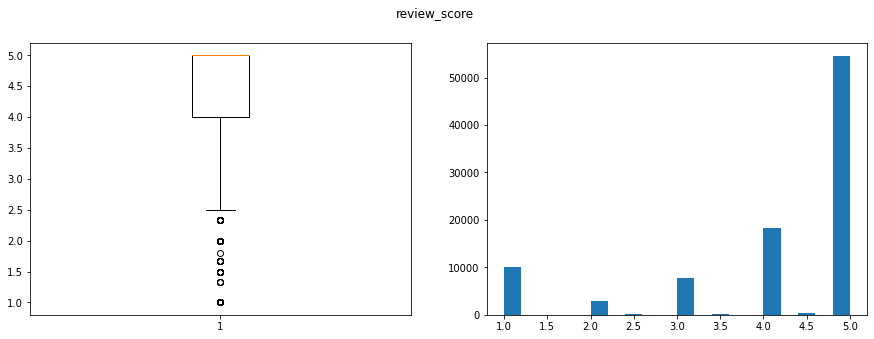

In [21]:
# ajout des review au df des commandes/clients
df_orders_cust = pd.merge(df_orders_cust
                          , df_order_reviews[['order_id','review_score']]
                          , on = 'order_id'
                          , how = 'inner')

df_sat_cli = df_orders_cust.groupby('customer_unique_id')[['review_score']].mean()

fig, (ax1, ax2) = plt.subplots(1,2)
fig.suptitle('review_score')
fig.set_figheight(5)
fig.set_figwidth(15)
ax1.boxplot(df_sat_cli['review_score'])
ax2.hist(df_sat_cli['review_score'], bins = 20)
plt.show();

Je peux voir que les clients sont majoritairement, en moyenne, très satisfait de leur commande.

Maintenant que j'ai fait ma segmentation RFM et que je l'ai analysé ainsi que la satisfaction client, je vais exporter ses données dans un fichier pour la modélisation et créer et exporter le fichier destiné au contrat de maintenance.

# Exportation
## Modélisation

In [22]:
df_final1 = pd.merge(df_RFM
                     , df_sat_cli
                     , on = 'customer_unique_id'
                     , how = 'inner')
del df_RFM, df_sat_cli

df_final1.to_csv('E:/Formations/6. Diplôme Data Scientist/Projet/Projet-5/olist_model.csv', index = False)

## Contrat de maintenance

In [23]:
df_final2 = df_orders_cust[['order_id','customer_unique_id','order_purchase_timestamp','payment_value','review_score']].copy()
del df_orders_cust

df_final2.to_csv('E:/Formations/6. Diplôme Data Scientist/Projet/Projet-5/olist_maintenance.csv', index = False)

In [24]:
for df in listDF:
    del globals()[df]